<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other functions</a></span><ul class="toc-item"><li><span><a href="#Filter" data-toc-modified-id="Filter-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Filter</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Clustering</a></span></li><li><span><a href="#Classify" data-toc-modified-id="Classify-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Classify</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Evaluation</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Plotting</a></span></li><li><span><a href="#Grid-Wrapper" data-toc-modified-id="Grid-Wrapper-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Grid Wrapper</a></span></li></ul></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Options</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize</a></span><ul class="toc-item"><li><span><a href="#Graph" data-toc-modified-id="Graph-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Graph</a></span></li></ul></li></ul></div>

# Clustering

## Description

- Cluster funds using Spektral Clustering

## Setup

In [49]:
import feather
from itertools import product
from multiprocessing import Pool

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from scipy.spatial.distance import euclidean

from minisom import MiniSom

import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.neighbors import kneighbors_graph, KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut

from graph_tool.all import *
import cairo

In [50]:
### Returns
path = '../data/processed/returns.feather'
returns = feather.read_dataframe(path)
returns = returns.rename(columns = {'caldt' : 'report_dt'})
returns = returns.assign(year = returns['report_dt'].dt.year)

### row_info
path = '../data/processed/row_info.feather'
row_info = feather.read_dataframe(path)
le = LabelEncoder()
row_info['lipper_class_num'] = le.fit_transform(row_info['lipper_class'])

### col_info
path = '../data/processed/col_info.feather'
col_info = feather.read_dataframe(path)

### Holdings
path = '../data/processed/holdings.npz'
holdings = sparse.load_npz(path)

## Other functions

### Filter

In [51]:
def filter_data(param, verbose = False):
    
    verbose = param['verbose']
    year = param['year']
        
    row_info_f = row_info.copy()
    if (year != 'full'):    # If year = full take whole sample
        row_info_f = row_info_f.query('year == @year')

    begin_date = row_info_f.iloc[0,:]['report_dt']
    end_date = begin_date + pd.DateOffset(years=1) # 1 year offset
    row_info_f.reset_index(drop = True, inplace=True)

    # Filter returns
    crsp_fundno_unique = row_info_f['crsp_fundno'].unique()
    returns_f = returns.copy()
    query = '''report_dt >= @begin_date and report_dt <= @end_date and crsp_fundno in @crsp_fundno_unique'''
    returns_f = returns_f.query(query)

    # Change return of month for which holdings apply to 0
    returns_f = returns_f.copy()
    mask = returns_f['report_dt'] == begin_date
    returns_f.loc[mask,'mret'] = 0
    
    # Drop all funds with first return observation after starting date
    drop_fundnos = returns_f.drop_duplicates('crsp_fundno').query('mret != 0')['crsp_fundno']
    returns_f.query('crsp_fundno not in @drop_fundnos', inplace=True)
    row_info_f.query('crsp_fundno not in @drop_fundnos', inplace=True)
    
    # Filter holdings accordingly and delet all securities with less than two observations
    holdings_f = holdings.copy()
    holdings_f = holdings[row_info_f['row']]
    
    holdings_b = sparse.csr_matrix(holdings_f, copy=True)
    holdings_b.data = np.ones(len(holdings_f.data))

    sum_sec_boolean = holdings_b.toarray().sum(0)
    col_mask = (sum_sec_boolean >= 2).flatten()

    holdings_f = holdings_f.tocsc()
    holdings_f = holdings_f[:,col_mask]
    holdings_f = holdings_f.tocsr()
    
    ## Preprocessing
    preprocessing = param['preprocessing']
    if (preprocessing == 'none'): holdings_ft = holdings_f
    if (preprocessing == 'l1'):   holdings_ft = normalize(holdings_f, norm = 'l1')
    if (preprocessing == 'l2'):   holdings_ft = normalize(holdings_f, norm = 'l2')

    
    if (verbose):
        print('Numer of unique funds:           {:10,d}'.format(row_info_f.shape[0]))

        print('Numer of unique securities:      {:10,d}'.format(holdings_ft.shape[1]))

        print('Begin date:                      {}'.format(begin_date.date()))
        print('End date:                        {}'.format(end_date.date()))
    
    return(row_info_f, returns_f, holdings_ft, begin_date, end_date)

### Clustering

In [52]:
def spectral_clustering(holdings_ft, param):
    verbose = param['verbose']

    if(verbose): print('Start clustering...')
    clustering = SpectralClustering(n_clusters = param['n_clusters'],
                                    assign_labels = param['assign_labels'], # kmeans or discretize
                                    eigen_solver = 'arpack',
                                    affinity = param['affinity'],
                                    gamma = param['gamma'],
                                    n_init = param['n_init'],
                                    n_jobs = -1,
                                    random_state = 0).fit(holdings_ft)
    if(verbose): print('Clustering finished')
    
    return(clustering.labels_)

In [53]:
def kmeans_clustering(holdings_ft, param):
    verbose = param['verbose']

    if(verbose): print('Start clustering...')
    clustering = KMeans(n_clusters = param['n_clusters'],
                        verbose = verbose,
                        n_init = param['n_init'], # Number of runs
                        n_jobs= -1,
                        random_state = 1
                       ).fit(holdings_ft)
    
    if(verbose): print('Clustering finished')
    
    return(clustering.labels_)

In [54]:
def som_clustering(holdings_ft, param):
    verbose = param['verbose']
    if(verbose): print('Start clustering...')
    
    ### Initialization and training ###
    # Configure SOM
    som = MiniSom(x = 25,
                  y = 25,
                  input_len = holdings_ft.shape[1],
    #             neighborhood_function = 'triangle',
                  sigma = 2.0,
                  learning_rate = 0.5)

    # Initialize
    data = holdings_ft.toarray()
    som.random_weights_init(data)

    # Train
    som.train_random(data, param['training_epochs'], verbose = verbose) # training with 100 iterations
    
    som_quantized = som.quantization(data)

    clustering = KMeans(n_clusters = param['n_clusters'],
                        verbose = verbose,
                        n_init = param['n_init'], # Number of runs
                        n_jobs= -1,
                        random_state = 1
                       ).fit(som_quantized)

    if(verbose): print('Clustering finished')    
    return(clustering.labels_)

### Classify

In [168]:
def knn_loo(row_info_f, holdings_f, param):
    
    verbose = param['verbose']
    if(verbose): print('Start clustering...')
    
    #### Setup ####
    # Classifier
    neigh = KNeighborsClassifier(n_neighbors = param['n_neighbors'], 
                                 p           = param['distance_param'], 
                                 weights     = param['weights'], 
                                 n_jobs      = 1) # distance or uniform
    
    # Data
    X = holdings_f
    y = row_info_f['lipper_class'].values
    n_rows = holdings_f.shape[0]

    #### Full #### 
    # Predict all at once and save in style_df
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    
    y_result = y.copy()

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        neigh.fit(X_train,y_train)
        y_result[test_index] = neigh.predict(X_test)
    
    return(y_result)

In [169]:
def classify(row_info_f, holdings_f, param, verbose=False):
    np.random.seed()
    
    if param.loc[0,'weights'] == 1:
        weights = 'distance'
    if param.loc[0,'weights'] == 2:
        weights = 'uniform'

    if param.loc[0,'preprocessing'] == 1:
        preprocessing = 'l1'
    if param.loc[0,'preprocessing'] == 2:
        preprocessing = 'l2'
        
    #### Setup ####
    # Classifier
    neigh = KNeighborsClassifier(n_neighbors = param.loc[0,'n_neighbors'].astype(int), 
                                 p           = param.loc[0,'distance_param'].astype(int), 
                                 #metric      = 'hamming'
                                 weights     = weights, 
                                 n_jobs      = 1) # distance or uniform
    
    # Data
    X = holdings_f
    y = row_info_f['lipper_class'].values
    n_rows = holdings_f.shape[0]

    # Result dataframe
    style_df = pd.DataFrame({'model_lipper' : y})

    #### Full #### 
    # Predict all at once and save in style_df
    loo = LeaveOneOut()
    loo.get_n_splits(X)

    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        neigh.fit(X_train,y_train)
        style_df.loc[test_index, 'model_knn_loo'] = neigh.predict(X_test)

    #### Iterative ####
    style_df['model_knn_iterative'] = style_df['model_lipper']
    
    # Index : Setup of index for choosing rows iteratively
    index = np.arange(n_rows)
    np.random.shuffle(index)
    index = np.concatenate((index,index,index,index,index))
    
    n_rows_chosen = round(n_rows * param.loc[0,'perc_rows_used']).astype(int)
    index = index[:n_rows_chosen]
    it = iter(index)
    index = zip(it)
    chosen_indices = []

    # Loop over n_iterations, choose one observation randomly, predict label, save and repeat
    f = FloatProgress(min=0, max=n_rows_chosen)
    if(verbose): 
        display(f)

    for i in index:
        mask = np.arange(X.shape[0]) # mask for whole sample
        mask_is = ~np.isin(mask,i)   # mask to choose all in sample observations
        mask_oos = np.isin(mask,i)   # mask to choose the x out of sample observations for which we predict
        chosen_indices.append(i)

        # Mask X and labels to exclude row for which prediction will be made
        X_sub = X[mask_is]
        y_sub = style_df.loc[mask_is,'model_knn_iterative'].values

        # Fit knn model on all but randomly chosen row
        neigh.fit(X_sub,y_sub) 

        # Predict and save label for randomly chosen row
        style_df.loc[mask_oos,'model_knn_iterative'] = neigh.predict(X[mask_oos])
        f.value += 2

    row_chosen = np.unique(np.array(chosen_indices).flatten()).shape[0]
    #print('Rows randomly chosen:    {:4.2f}%'.format(row_chosen / X.shape[0] * 100))
    #print('Done')
    
    return(style_df)

### Evaluation

In [170]:
def calc_styleadj_returns(row_info_f, returns_f, style_cols):

    row_info_m = row_info_f.copy()
    returns_m = returns_f.copy()
    
    returns_m = returns_m.sort_values(['crsp_fundno','report_dt'])

    # merge predicted styles onto returns
    returns_m = returns_m.merge(row_info_m[['crsp_fundno', 'report_dt', style_cols]],
                            how='left',
                            on=['crsp_fundno', 'report_dt'])

    # Forward fill all styles and drop nas
    returns_m = (returns_m.apply(lambda x: x.fillna(method = 'ffill'))
    )

    # Calc mean return per style
    style_returns = (returns_m
                        .groupby([style_cols,'report_dt'])
                        .mean()
                        .reset_index()
                        .drop(columns='crsp_fundno')
    )

    # Merge style returns onto fund returns and calc tracking error
    returns_m = (returns_m
                        .rename(columns = {'mret' : 'fund_ret'}) 
                        .merge(style_returns,
                                    how = 'left',
                                    on = [style_cols,'report_dt'])
                        .assign(error = lambda df: df['fund_ret'] - df['mret'])
                        .rename(columns = {'mret' : 'style_ret'}) 
    )

    returns_m = returns_m[['crsp_fundno', 'report_dt', style_cols,
                       'fund_ret', 'style_ret', 'error']]

    return(returns_m, style_returns)

In [171]:
def error_vola_deciles(returns_m): 
    error_vol = (returns_m
                 .groupby(['crsp_fundno'])['error']
                 .std()
                 .reset_index())
    error_vol['error'] = error_vol['error'] * 100
    
    error_vol = (error_vol[['error']]
                .apply(lambda x : x.quantile(np.round(np.arange(0.1,1,0.1),2))))
    return(error_vol)

def error_vola_describe(returns_m): 
    error_vol = (returns_m
                 .groupby(['crsp_fundno'])['error']
                 .std()
                 .reset_index())
    error_vol['error'] = error_vol['error'] * 100
    return(error_vol[['error']].describe().T)

In [172]:
def simulation(row_info_f, returns_f, n_iterations):
    np.random.seed()

    #n_iterations = 500
    
    # First choose n samples of funds with one fund per cluster
    funds_list = []
    cluster = np.array(row_info_f[['crsp_fundno','cluster']])
    arr = np.arange(row_info_f.shape[0])

    for i in np.arange(n_iterations):
        np.random.shuffle(arr)
        cluster = cluster[arr]
        index = np.unique(cluster[:,1], return_index = True, return_inverse = False)[1]
        funds = cluster[index,0]
        funds_list.append(funds)


    mean_return = []
    mean_std = []
    returns_fundnos = returns_f['crsp_fundno'].values

    for funds in funds_list:
        # Take returns for sample and calc equally weighted average return
        returns_index = np.isin(returns_fundnos,funds)
        returns_s = returns_f[returns_index]
        returns_s = returns_s.groupby('report_dt')['mret'].mean()

        # Calc mean and std
        mean_return.append(returns_s.std())
        mean_std.append(returns_s.mean())


    mean_return = pd.DataFrame(mean_return).mean()
    mean_std = pd.DataFrame(mean_std).mean()
    
    return([mean_return[0], mean_std[0]])

In [173]:
def simulation_wrapper(row_info_f, returns_f, n_iterations):
    result_list = []
    pool = Pool()
    
    for i in range(n_iterations):
        pool.apply_async(simulation, callback = result_list.append)
    pool.close()
    pool.join()
    result = result_list
    return(result)

### Plotting

In [174]:
def style_map(row_info_f):
    cap = [0,1,2,3]
    style = [0,1,2]

    counts = row_info_f['cluster'].value_counts().sort_index()
    size = np.round(counts / 10)

    data = round(
            pd.crosstab(
                row_info_f['cap_class'],row_info_f['cluster'], 
                margins = True, normalize = 'columns') * 100, 2).T

    x = data.apply(lambda x: np.sum(x * cap) / 100, axis = 1)

    data = round(
            pd.crosstab(
                row_info_f['style_class'],row_info_f['cluster'], 
                margins = True, normalize = 'columns') * 100, 2).T
    y = data.apply(lambda x: np.sum(x * style) / 100, axis = 1)

    label = x.index[:-1]

    fig = plt.figure(figsize=(15,4))
    ax_s = fig.add_subplot(111)

    #ax_s.grid(True)

    plt.xlabel('Market cap dimension')
    plt.xticks([0,1,2,3], ['SC','MC','ML','LC'])

    plt.ylabel('Style dimension')
    plt.yticks([0,1,2], ['V','C','G'])

    for i, txt in enumerate(label):
        ax_s.annotate(txt, (x[i], y[i]),
                     xytext = (0, 0),              # Horizontally shift label by `space`
                     textcoords = 'offset points', # Interpret `xytext` as offset in points
                     va='center',                  # Vertically center label
                     ha='center',
                     color = 'black',
                     size = size[i])  

    plt.show()
    
def plot_cluster(row_info_f, style, ax):
    data = round(
        pd.crosstab(
            row_info_f[style],row_info_f['cluster'], 
            margins = True, normalize = 'columns') * 100, 2).T

    data.plot(kind='bar', 
                 stacked=True, ax = ax)

    ax.legend().remove()
    label_list = data.columns.values.astype(str).repeat(data.shape[0])
    rects = ax.patches

    # For each bar: Place a label
    for i, rect in enumerate(rects):
        if rect.get_height() > 10:
            # Get X and Y placement of label from rect.
            x_value = rect.get_x() + rect.get_width() / 2
            y_value = rect.get_y() + rect.get_height() / 2

            # Use X value as label and format number with one decimal place
            label = "{}".format(label_list[i])

            # Create annotation
            ax.annotate(
                label,                        # Use `label` as label
                (x_value, y_value),           # Place label at end of the bar
                xytext = (0, 0),              # Horizontally shift label by `space`
                textcoords = 'offset points', # Interpret `xytext` as offset in points
                va='center',                  # Vertically center label
                ha='center',
                color = 'white',
                size = 12)                  # Horizontally align label 
    return(ax)
    
def plot_cluster_wrapper(row_info_f):
    
    f, axes = plt.subplots(nrows = 4, ncols=1, sharex=True, 
                           figsize = (15,6), gridspec_kw={'height_ratios':[1,2,2,2]})
    
    data = row_info_f['cluster'].value_counts(sort=False).append(to_append = pd.Series([0]))
    data.plot(kind='bar', ax = axes[0])
    axes[0].annotate('Total: {:,d}'.format(np.sum(data)),(12,100),ha ='center',size=14)

    plot_cluster(row_info_f,'cap_class', ax = axes[1])
    plot_cluster(row_info_f,'style_class', ax = axes[2])
    plot_cluster(row_info_f,'lipper_class', ax = axes[3])
    plt.show()
    style_map(row_info_f)

### Grid Wrapper

In [175]:
def expand_grid(dictionary):
    temp = pd.DataFrame([row for row in product(*dictionary.values())], 
                           columns=dictionary.keys())
    return(temp)

In [176]:
def weighted_average_score(param_grid, relevant_params, measures):

    param_grid = param_grid.fillna(value=0)
    param_grid['param_id'] = (param_grid
                                  .groupby(relevant_params)
                                  .ngroup())
    
    # Fix for issue with same param_id for lipper rows
    lipper_rows = param_grid.loc[param_grid['algo'] == 'lipper',:].copy()
    lipper_rows['param_id'] = lipper_rows.groupby(['preprocessing']).ngroup()
    lipper_rows['param_id'] = (lipper_rows['param_id'] + 1) * -1
    param_grid.loc[param_grid['algo'] == 'lipper'] = lipper_rows

    scores = param_grid[measures]
    params_only = param_grid.drop(columns = measures)
    
    weights = (param_grid[['year','count']]
                                  .drop_duplicates()
                                  .assign(weight = lambda x: x['count'] / np.sum(x['count'])))
    weights = weights[['weight']].values

    scores = scores.groupby(params_only['param_id']).apply(lambda x: np.sum(x * weights))

    params_only = (params_only
                      .drop_duplicates(relevant_params)
                      .drop(columns = ['year','count']))

    result = params_only.merge(scores, how = 'left', on = 'param_id')
    
    return(result)

In [180]:
def full_algo(param_grid):
    
    # Setup
    n_row = param_grid.shape[0]
    cluster_list = []
    result_grid = param_grid.copy()
    
    # Loop over all supplyed params
    print('Start with params...')
    for i, param in param_grid.iterrows():
        row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(param)
        
        algo = param['algo']
        if(algo == 'knn_loo'):  cluster = knn_loo(row_info_f, holdings_ft, param)
        
        if(algo == 'spectral'): cluster = spectral_clustering(holdings_ft, param)
        if(algo == 'kmeans'):   cluster = kmeans_clustering(holdings_ft, param)
        if(algo == 'som'):      cluster = som_clustering(holdings_ft, param)
        
        print(cluster)
        row_info_f = row_info_f.assign(cluster = cluster)
        cluster_list.append(cluster)

        db_score = davies_bouldin_score(holdings_ft.toarray(), row_info_f['cluster'])
        s_score = silhouette_score(holdings_ft, row_info_f['cluster'])

        result_grid.loc[i,'count'] = row_info_f.shape[0]
        result_grid.loc[i,'score db'] = db_score
        result_grid.loc[i,'score silhouette'] = s_score

        # sim_results = simulation(row_info_f, returns_f, n_iterations = 500)
        # result_grid.loc[i,'sim mret'] = sim_results[0]
        # result_grid.loc[i,'sim std'] = sim_results[1]

        returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f, style_cols='cluster')
        result_grid.loc[i,'median tevola'] = error_vola_describe(returns_m)['50%'][0]
        
        progress = (i+1) / n_row * 100
        print('Progress:                                          {:<5.2f}%'.format(progress))
    

    # Evaluate standart lipper classification
    print('Evaluate Lipper clusters...')
    years = param_grid['year'].unique()
    preprocessing = param_grid['preprocessing'].unique()

    lipper_grid = pd.DataFrame()
    param_lipper = dict(
                    year = years,
                    preprocessing = preprocessing,
                    verbose = [False]
                    )
    param_grid_lipper = expand_grid(param_lipper)
        
    for i, param_lipper in param_grid_lipper.iterrows():
        row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(param_lipper)
        row_info_f = row_info_f.assign(cluster = row_info_f['lipper_class_num'])
        cluster_list.append(row_info_f['lipper_class_num'])

        db_score = davies_bouldin_score(holdings_ft.toarray(), row_info_f['cluster'])
        s_score = silhouette_score(holdings_ft, row_info_f['cluster'])

        lipper_grid.loc[i,'year'] = param_lipper['year']
        lipper_grid.loc[i,'count'] = row_info_f.shape[0]
        lipper_grid.loc[i,'score db'] = db_score
        lipper_grid.loc[i,'score silhouette'] = s_score
        lipper_grid.loc[i,'algo'] = 'lipper'
        lipper_grid.loc[i,'preprocessing'] = param_lipper['preprocessing']

        # sim_results = simulation(row_info_f, returns_f, n_iterations = 500)
        # lipper_grid.loc[i,'sim mret'] = sim_results[0]
        # lipper_grid.loc[i,'sim std'] = sim_results[1]
        
        returns_m, style_returns = calc_styleadj_returns(row_info_f, returns_f, style_cols='cluster')
        lipper_grid.loc[i,'median tevola'] = error_vola_describe(returns_m)['50%'][0]
        
    # Concat and calc year weighted averages
    param_grid_full = pd.concat([result_grid,lipper_grid], axis = 0, sort=False)
    result = weighted_average_score(param_grid_full,
                                    relevant_params = ['n_clusters','assign_labels',
                                                       'affinity','gamma','n_init','algo','preprocessing',
                                                        'n_neighbors', 'distance_param', 'weights'],
                                    measures = ['score db', 'score silhouette', 'median tevola'])
    result = result.drop(columns = ['verbose'])
    result['years'] = '{} - {}'.format(np.min(years), np.max(years))
    print('                                              ... Finished')

    return(result, cluster_list)

## Clustering

### Options

In [178]:
full = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
param = dict(
    year             = [2014],          # Integer or string 'full' for the whole sample
    algo             = ['knn_loo'],    # 'kmeans','spectral','som'
    n_clusters       = [10], 
    preprocessing    = ['l1','l2'], 
    
    # K-means and SOM
    n_init           = [10],             # N init of kmeans
    
    # spectral specific
    assign_labels    = ['kmeans'],      # 'kmeans' or 'discretize'
    affinity         = ['rbf'],         # One of: rbf, nearest_neighbors
    gamma            = [1],             # Sigma for rbf kernal

    # som specific
    training_epochs  = [1_000],
    
    # Classification
    n_neighbors     = [10],
    distance_param  = [1],       # 1: manhattan distance, 2: euclidian distance
    weights         = ['uniform', 'distance'],          # One of 1: (distance) or 2: (uniform)
    
    verbose          = [True]
)

param_grid = expand_grid(param)

In [181]:
result, cluster_list = full_algo(param_grid)

Start with params...
Numer of unique funds:                1,989
Numer of unique securities:           5,319
Begin date:                      2014-12-31
End date:                        2015-12-31
Start clustering...
[LCVE, LCVE, LCVE, LCVE, LCGE, ..., LCCE, LCVE, MCGE, MCVE, SCCE]
Length: 1989
Categories (13, object): [EIEI < LCVE < LCCE < LCGE ... MCGE < SCVE < SCCE < SCGE]
Progress:                                          25.00%
Numer of unique funds:                1,989
Numer of unique securities:           5,319
Begin date:                      2014-12-31
End date:                        2015-12-31
Start clustering...
[LCVE, LCVE, MCVE, LCVE, LCGE, ..., LCCE, LCVE, MCGE, MCVE, SCCE]
Length: 1989
Categories (13, object): [EIEI < LCVE < LCCE < LCGE ... MCGE < SCVE < SCCE < SCGE]
Progress:                                          50.00%
Numer of unique funds:                1,989
Numer of unique securities:           5,319
Begin date:                      2014-12-31
End date:      

In [182]:
result

,algo,n_clusters,preprocessing,n_init,assign_labels,affinity,gamma,training_epochs,n_neighbors,distance_param,weights,param_id,score db,score silhouette,median tevola,years
0,knn_loo,10.0,l1,10.0,kmeans,rbf,1.0,1000.0,10.0,1.0,uniform,3,7.016935,-0.007287,0.889414,2014 - 2014
1,knn_loo,10.0,l1,10.0,kmeans,rbf,1.0,1000.0,10.0,1.0,distance,2,7.188108,-0.008306,0.886173,2014 - 2014
2,knn_loo,10.0,l2,10.0,kmeans,rbf,1.0,1000.0,10.0,1.0,uniform,5,5.409033,0.002931,0.988894,2014 - 2014
3,knn_loo,10.0,l2,10.0,kmeans,rbf,1.0,1000.0,10.0,1.0,distance,4,6.937489,0.002979,0.978445,2014 - 2014
4,lipper,0.0,l1,0.0,0,0,0.0,0.0,0.0,0.0,0,-1,7.755873,-0.008485,0.872958,2014 - 2014
5,lipper,0.0,l2,0.0,0,0,0.0,0.0,0.0,0.0,0,-2,7.605421,0.009735,0.872958,2014 - 2014


## Visualize

In [ ]:
model_index = 1
cluster = cluster_list[model_index]
param = param_grid.iloc[model_index,:]

In [ ]:
row_info_f, returns_f, holdings_ft, begin_date, end_date = filter_data(param)
row_info_f = row_info_f.assign(cluster = cluster)

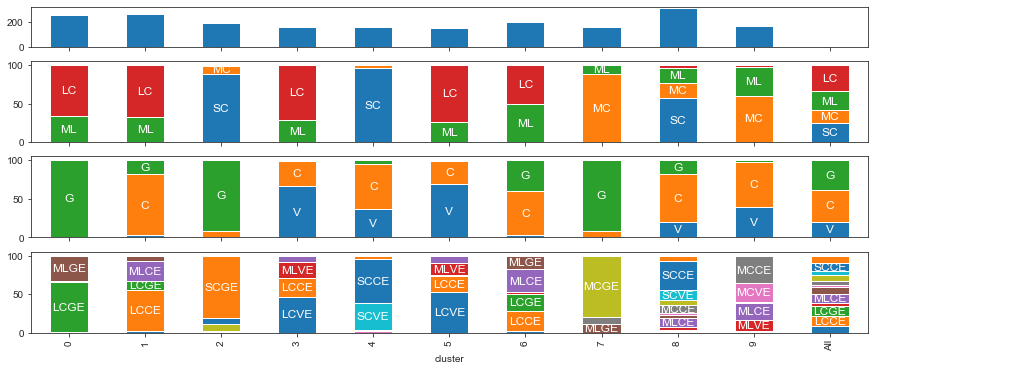

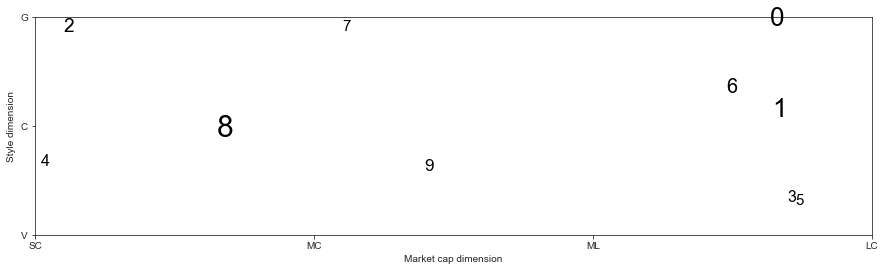

In [32]:
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 14, "ytick.major.size": 14})

plot_cluster_wrapper(row_info_f)

In [ ]:
fig, ax1 = plt.subplots(figsize = (14,4))

ax2 = ax1.twinx()

sns.lineplot(data = result ,x = 'n_clusters', y='DB score', color='g', ax=ax1)
sns.lineplot(data = result ,x = 'n_clusters', y='Silhouette score', ax=ax2)

ax1.set_xlabel('n_cluster')
ax1.set_ylabel('DB score', color='g')
ax2.set_ylabel('Slihouette score', color='b')

plt.show()

### Graph

In [51]:
size = holdings_ft.shape[0]

raw_data = holdings_ft[0:size]

graph_data = kneighbors_graph(raw_data, 
                              n_neighbors = 7,
                              mode = 'distance',
                              p = 1)

In [52]:
le = LabelEncoder()
cluster_encoded = le.fit_transform(row_info_f['cluster'])

cluster = cluster_encoded
cluster_text = row_info_f.loc[:size,'cluster']

distance = graph_data.data
vertex_n = graph_data.shape[0]

x, y = graph_data.nonzero()

g = Graph(directed=False)
g.add_vertex(vertex_n)

for s , t in zip(x,y):
    g.add_edge(g.vertex(s), g.vertex(t))

cluster_text.values

v_cluster = g.new_vertex_property('int', vals = cluster)
v_text = g.new_vertex_property("string", vals = cluster_text.values)

In [53]:
e_distance = g.new_edge_property('double', vals = distance)

e_distance = prop_to_size(e_distance, mi=1, ma=10, log=False, power=0.5)

In [54]:
pos = sfdp_layout(g, eweight = e_distance)

In [55]:
print(result.iloc[model_index])

algo                     kmeans
n_clusters                   10
preprocessing                l2
n_init                       10
assign_labels            kmeans
affinity                    rbf
gamma                         1
training_epochs            1000
param_id                      3
score db                5.36443
score silhouette      0.0284591
median tevola          0.876703
years               2014 - 2014
Name: 1, dtype: object


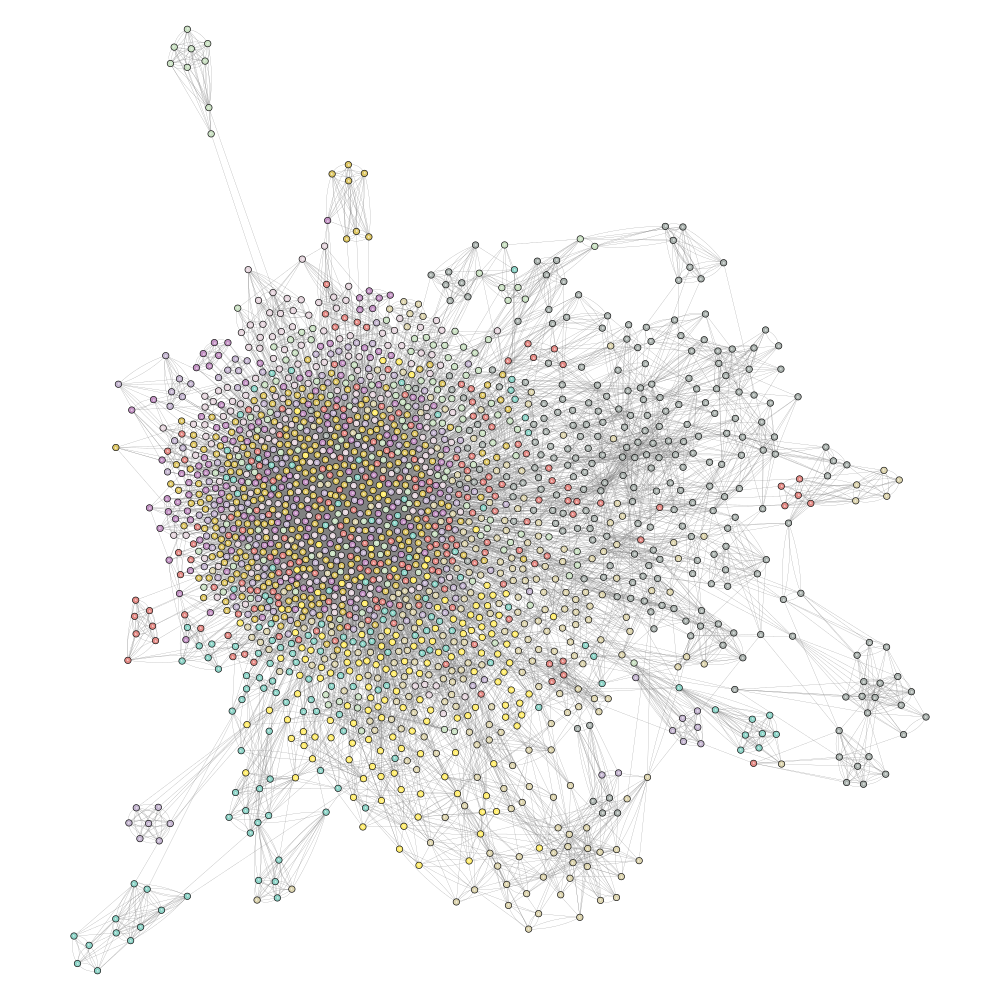

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x15c2fc550, at 0x15bbcbfd0>

In [56]:
graph_draw(g, 
           output_size = (1000,1000), 
           #output = 'test.pdf',
           vprops = {#'size' : 1,
                     'color' : 'black',
                     'fill_color' : v_cluster,
                     'text' : v_text,
                     'text_color' : 'white',
                     'font_size' : 3,
                     'font_weight' : cairo.FONT_WEIGHT_BOLD,
                     'halo' : False,
                     'halo_color' : v_cluster,
                     'halo_size' : 1
                    },
           eprops = {'pen_width' : 0.2,
                     'color' : 'grey'}
           )

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Other-functions" data-toc-modified-id="Other-functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Other functions</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Options" data-toc-modified-id="Options-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Options</a></span></li><li><span><a href="#Spectral" data-toc-modified-id="Spectral-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Spectral</a></span></li><li><span><a href="#K-means" data-toc-modified-id="K-means-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>K-means</a></span></li></ul></li><li><span><a href="#Visualize" data-toc-modified-id="Visualize-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Visualize</a></span></li><li><span><a href="#Chart-the-returns-of-the-formed-clustes" data-toc-modified-id="Chart-the-returns-of-the-formed-clustes-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Chart the returns of the formed clustes</a></span></li><li><span><a href="#Analysing-clusters" data-toc-modified-id="Analysing-clusters-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Analysing clusters</a></span></li></ul></div>